In [13]:
from processed_data import GreyUTKFace
from models.GreyUTKFaceVAE import Model as VAE
from utils import device
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch

# VAE Model

In [2]:
model = VAE(device)
model.to(device)
model.load()
pass

# A Face

In [3]:
test_dataset = GreyUTKFace.Dataset(train=False, sample=False)

In [4]:
a_face, an_age = test_dataset[0]

Text(0.5,1,'26')

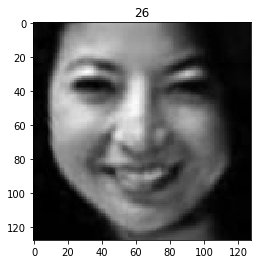

In [5]:
plt.imshow(a_face.view(128, 128).cpu(), cmap='gray')
plt.title(an_age)

# Encoding and Reconstruction Face

In [6]:
a_face = a_face.to(device)

In [7]:
encoded_face, _ = model.encode(a_face)
encoded_face

tensor([[-0.9004,  0.4838, -0.2439, -0.2676, -1.7577, -0.6721,  0.6496, -0.8634,
          1.8183,  0.2855,  1.4066, -0.7586, -2.3237, -1.2585,  1.0214, -2.0552,
          0.7118,  0.6456, -1.9625,  0.3993,  0.0536, -0.0584,  1.0464, -0.1908,
          0.9523, -1.1005,  0.0675,  0.7515,  4.5439, -0.9655, -0.4512, -1.0844,
         -0.9506, -0.4734, -0.1890,  0.1037, -0.0185,  1.0368,  0.1320,  0.1641,
          0.6331, -0.8914, -0.6001,  1.5035, -2.0397, -0.3861, -0.4444, -0.8881,
         -1.4269, -0.4574]], device='cuda:0', grad_fn=<AddmmBackward>)

In [8]:
reconst_face = model.decode(encoded_face)

# Prediction of Faces and Various Ages

In [9]:
def predict_face(encoded_face, age, target_age, model):
    # Transition Age Vector in Latent Space

    def avg_age_encoded_face(age):
        items = test_dataset.get_faces_of_age(age)
        faces = list(map(lambda item: item[0].numpy(), items))
        faces = np.array(faces)
        face_imgs = torch.from_numpy(faces).to(device)
        means, _ = model.encode(face_imgs)
        avg_encoded_face = torch.mean(means, dim=0)
        return avg_encoded_face

    latent_source = avg_age_encoded_face(age)
    latent_target = avg_age_encoded_face(target_age)

    transition_vector = latent_target - latent_source
    transition_vector

    # Decoding Age Transition on Encoded Face

    aged_encoding = encoded_face + transition_vector
    aged_encoding

    aged_face = model.decode(aged_encoding)
    return aged_face

In [10]:
target_ages = [1, 5, 20, 40, 60, 80]

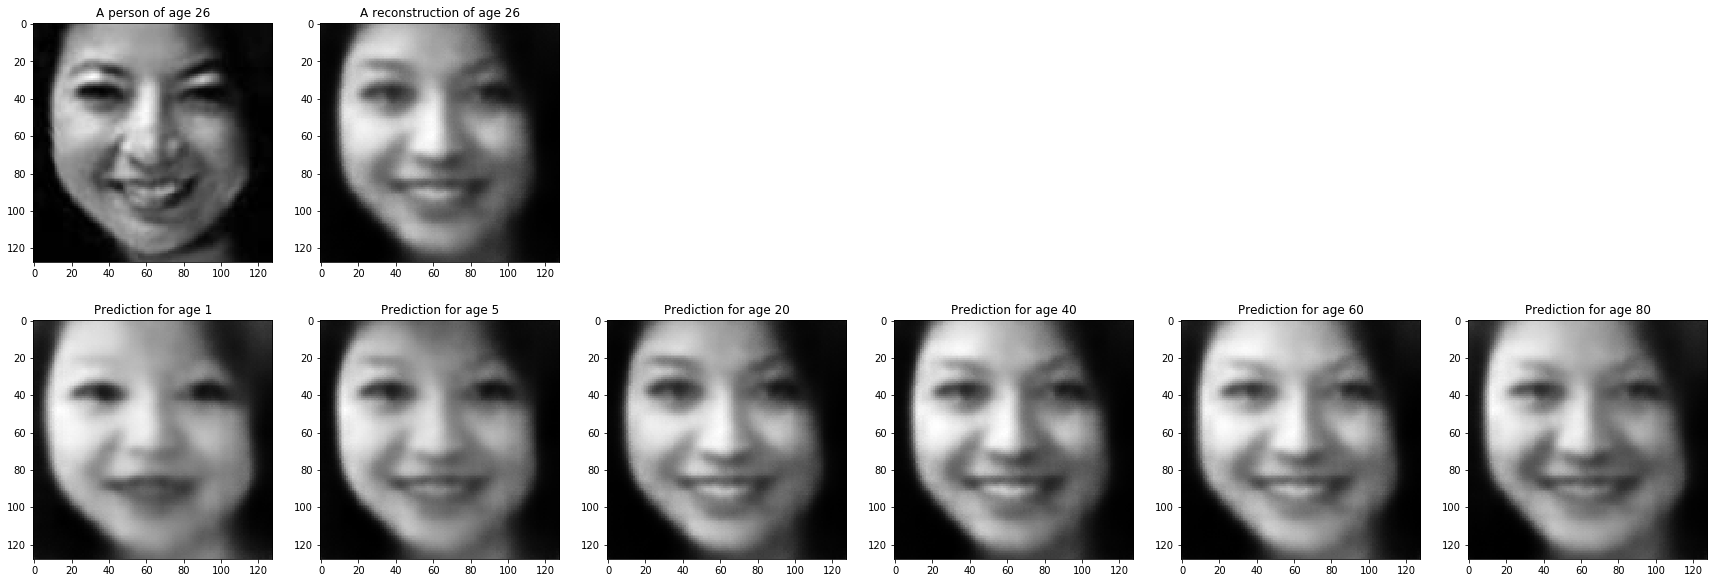

In [15]:
plt.figure(figsize=(len(target_ages) * 5, 10))
plt.subplot(2,len(target_ages), 1)
plt.imshow(a_face.view(128, 128).detach().cpu(), cmap='gray')
plt.title('A person of age {}'.format(an_age))

plt.subplot(2,len(target_ages), 2)
plt.imshow(reconst_face.view(128, 128).detach().cpu(), cmap='gray')
plt.title('A reconstruction of age {}'.format(an_age))

for i, target_age in enumerate(target_ages):
    plt.subplot(2,len(target_ages), len(target_ages)+i+1)
    
    aged_face = predict_face(encoded_face, an_age, target_age, model)
    
    plt.imshow(aged_face.view(128, 128).detach().cpu(), cmap='gray')
    plt.title('Prediction for age {}'.format(target_age))